# Anderson model of localization

## initializations

In [1]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [3]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

Using TensorFlow backend.


tensorflow:  2.0.0 , keras:  2.3.1
sklearn:  0.22.1


In [4]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [5]:
myseed = 123467

np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [6]:
img_sizeX= 100
img_sizeY= img_sizeX
validation_split= 0.1

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 16
dataname = 'data-L20-500-CO-NF-100'
datapath = '../'+dataname
modelname = '/model_'+dataname+'.h5'
modelpath = datapath+modelname
historyname = '/history_'+dataname+'.pkl'
historypath = datapath+historyname

#print(datapath,modelpath,historypath)

In [8]:
training_set = train_datagen.flow_from_directory(datapath,
                                                 subset='training',
                                                 target_size = (img_sizeX,img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='categorical',
                                                shuffle=True,seed=myseed)

validation_set= train_datagen.flow_from_directory(datapath, 
                                              subset='validation', 
                                              target_size = (img_sizeX,img_sizeY),
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                                 shuffle=False,seed=myseed)

# test_set = test_datagen.flow_from_directory('data-keras-L20-100/test_set',
#                                             target_size = (171, 171),
#                                             batch_size = batch_size,
#                                             class_mode='categorical',
#                                            shuffle=False)

Found 7650 images belonging to 17 classes.
Found 850 images belonging to 17 classes.


In [9]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

In [10]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

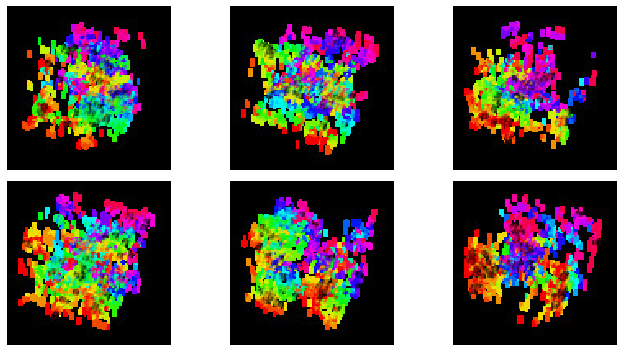

In [11]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## building the CNN

In [12]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(img_sizeX, img_sizeY, 3))

def create_CNN():
    # instantiate model
    model= Sequential([
        resnet,Flatten(),
        Dense(num_classes, activation='sigmoid'),
    ])
    
    return model

print('CNN architecture (Resnet50) created successfully!')

/home/phsht/bin/anaconda3/envs/TFGPU/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


CNN architecture (Resnet50) created successfully!


In [13]:
mylr=0.01
mywd=1e-6

# Choose the Optimizer and the Cost Function

opt = optimizers.SGD(lr=mylr, decay=mywd)
#opt = keras.optimizers.Adam(lr=mylr, decay=mywd)

def compile_model(optimizer=opt):
    # create the mode
    model=create_CNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [14]:
# opt = optimizers.SGD(lr=mylr, decay=mywd)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# create the deep neural net
model = compile_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                557073    
Total params: 24,144,785
Trainable params: 24,091,665
Non-trainable params: 53,120
_________________________________________________________________
None


## learning the images

In [15]:
# training parameters
myepochs=10

In [16]:
# train DNN and store training info in history
history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)

Epoch 1/10
478/478 [==============================] - 92s 192ms/step - loss: 2.8265 - accuracy: 0.0870 - val_loss: 2.7523 - val_accuracy: 0.0566
Epoch 2/10
478/478 [==============================] - 62s 129ms/step - loss: 2.8053 - accuracy: 0.1019 - val_loss: 2.6998 - val_accuracy: 0.0647
Epoch 3/10
478/478 [==============================] - 64s 135ms/step - loss: 2.7635 - accuracy: 0.1119 - val_loss: 2.3918 - val_accuracy: 0.1055
Epoch 4/10
478/478 [==============================] - 54s 114ms/step - loss: 2.6976 - accuracy: 0.1145 - val_loss: 2.1420 - val_accuracy: 0.1103
Epoch 5/10
478/478 [==============================] - 55s 116ms/step - loss: 2.6223 - accuracy: 0.1261 - val_loss: 2.0993 - val_accuracy: 0.0947
Epoch 6/10
478/478 [==============================] - 55s 115ms/step - loss: 2.5542 - accuracy: 0.1628 - val_loss: 2.2647 - val_accuracy: 0.1091
Epoch 7/10
478/478 [==============================] - 56s 117ms/step - loss: 2.4350 - accuracy: 0.2167 - val_loss: 2.4555 - val_ac

In [17]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
model.save(modelpath) 

import pickle 
f=open(historypath,"wb")
pickle.dump(history,f)
f.close()

## testing the quality of the learned model

In [18]:
#history = load_model(modelpath)

### training history

54/54 [==============================] - 2s 30ms/step

Test loss: 1.06669020652771
Test accuracy: 0.09058823436498642


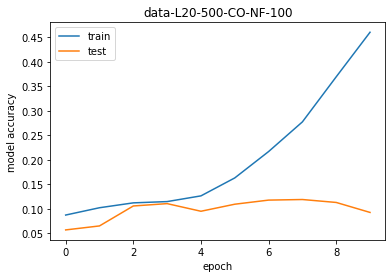

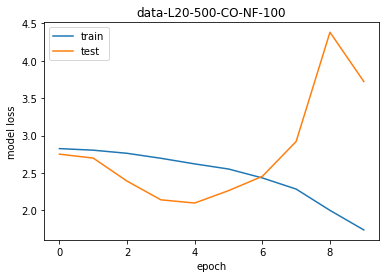

In [19]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_accuracy'+'.png')

# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_loss'+'.png')

### confusion matrix

In [20]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

54/54 [==============================] - 4s 81ms/step


array([[16,  4,  1,  7,  3, 10,  3,  1,  0,  1,  0,  1,  0,  2,  0,  0,
         1],
       [12,  1,  1,  6,  4,  7,  0,  7,  1,  2,  6,  0,  0,  0,  0,  0,
         3],
       [ 4,  1,  0, 12,  2, 10,  1,  3,  7,  3,  1,  1,  2,  1,  0,  0,
         2],
       [ 5,  1,  1,  4,  6,  9,  0,  5,  5,  5,  2,  0,  1,  2,  1,  0,
         3],
       [ 6,  0,  1,  8,  4,  8,  1,  3,  5,  1,  2,  0,  1,  4,  2,  0,
         4],
       [ 0,  1,  0,  6,  2, 11,  1,  3, 11,  1,  3,  4,  0,  2,  0,  0,
         5],
       [ 2,  0,  0,  4,  2,  7,  1,  9,  6,  6,  1,  1,  1,  5,  1,  0,
         4],
       [ 4,  0,  0,  4,  4,  6,  0,  5,  5,  3,  4,  0,  4,  4,  0,  1,
         6],
       [ 4,  0,  0,  6,  2,  8,  0,  0, 11,  2,  5,  2,  0,  2,  1,  1,
         6],
       [ 2,  2,  0,  6,  2,  9,  1,  5, 10,  2,  1,  0,  1,  4,  1,  0,
         4],
       [ 2,  0,  0,  4,  2, 12,  0,  6,  7,  4,  0,  2,  3,  2,  0,  1,
         5],
       [ 0,  2,  0,  3,  0,  5,  2,  9,  6,  2,  4,  0,  3,  3,  

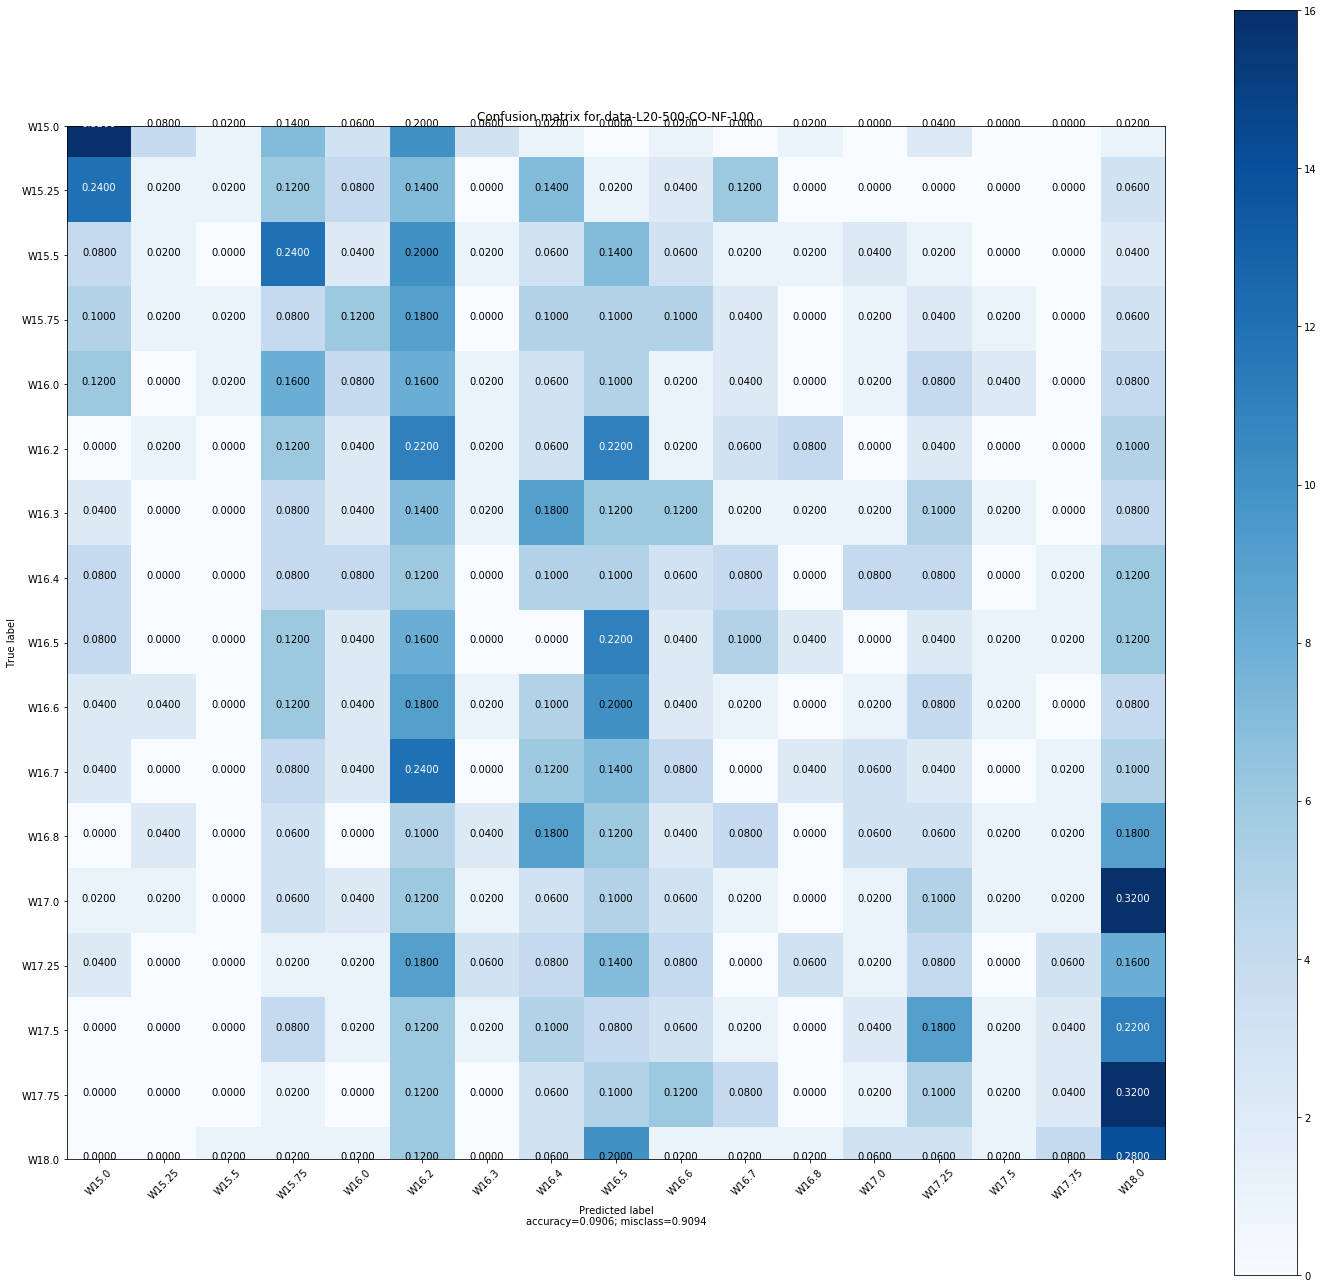

None


In [21]:
os.chdir('../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
os.chdir('../src/')

## modify the Hyperparameters to Optimize Performance of the Model

In [22]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [23]:
X_train, X_labels = next(training_set)
Y_train, Y_labels = next(validation_set)
len(X_train),len(X_labels),len(Y_train),len(Y_labels)

(16, 16, 16, 16)

In [24]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=1)

# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# define parameter dictionary
param_grid = dict(optimizer=optimizer)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(X_train,Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/home/phsht/bin/anaconda3/envs/TFGPU/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Invalid shape for y: (12, 100, 100, 3)

  FitFailedWarning)


ValueError: Invalid shape for y: (16, 100, 100, 3)